# CNN for Image Classification

### [2024.02.25] 이상혁

### 개요
- [출처] 딥러닝 파이토치 교과서 6장 3절의 이미지 분류를 위한 신경망
- 전이학습을 통한 강아지, 고양이 이미지 분류

### 0. GPU Configuration

💻빠른 연산을 위해 PyTorch에서 **GPU**를 사용할 수 있도록 설정해준다.

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# 시드 고정
import random
import os
import numpy as np

SEED = 225

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if device == 'cuda':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)

### 1. Libraries

In [51]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import datetime
import random
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy
import glob # for file handling
import cv2 # open source cv library
import shutil
from PIL import Image

import torch
import torchvision # CV
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [4]:
sys.path.append('C:/Python_Programs/Pytorch/4. CNN for Image Classification')
os.chdir('C:/Python_Programs/Pytorch/4. CNN for Image Classification')

### 2. Brief Info

이번에 진행할 주제는 이미지 내에 특정 대상이 존재하는지 여부를 판단하는 **이미지 분류(Image Classification)**이다. 그리고 이에 사용되는 **합성곱 신경망**의 구조를 살펴보자.
1. LeNet-5
- 이번에 사용할 모델은 LeNet-5이다. 현재 CNN의 초석이 된 모델이다.
- 합성곱층과 다운 샘플링 층을 반복적으로 사용하면서 마지막에 완전연결계층에서 분류를 수행한다.
- 합성곱 연산으로 특성 맵을 생성 -> 다운 샘플링 하여 특성 맵의 크기를 줄읾 -> 합성곱 연산으로 더 많은 특성 맵을 생성 -> ...
- 이번에도 Theme 3에서 사용한 강아지, 고양에 데이터셋을 사용

### 3. Data Load & Pre-processing

In [6]:
# 이미지 데이터 전처리용 클래스
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), # 이미지를 주어진 크기(resize)로 조정 + 이미지 면적의 50%~100%를 무작위로 자름
                transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지를 수평 반전
                transforms.ToTensor(), # 픽셀 값 범위 수정 및 (채널, 높이, 너비) 순으로 차원 순서 변경                
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase): # 인스턴스 호출 시 사용
        return self.data_transform[phase](img)

In [131]:
# Load data
cat_directory = r'C:/Python_Programs/Pytorch/4. CNN for Image Classification/Cat'
dog_directory = r'C:/Python_Programs/Pytorch/4. CNN for Image Classification/Dog'

# 'C:/Python_Programs/Pytorch/4. CNN for Image Classification/Cat\\cat.0.jpg' 와 같은 형식으로 만들어줌
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

image_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

correct_images_filepaths = [i for i in image_filepaths if cv2.imread(i) is not None] # 파일 경로 리스트로 생성 

In [103]:
# 400 Train data, 92 valiation data, 10 Test data
random.shuffle(correct_images_filepaths)
train_img_filepath = correct_images_filepaths[:400]
val_img_filepath = correct_images_filepaths[400:-10]
test_img_filepath = correct_images_filepaths[-10:]

print('Length of Train data :', len(train_img_filepath))
print('Length of Validation data :', len(val_img_filepath))
print('Length of Test data :', len(test_img_filepath))

Length of Train data : 400
Length of Validation data : 92
Length of Test data : 10


- 위 과정을 통해서 데이터를 불러오고 Train/Validaion/Test로 나누었다.
- 이제 Test 데이터에는 어떤 사진이 있는지 시각화해보자.

In [104]:
# kernel 충돌로 matplotlib.pyplot가 그려지지 않을 때 해결 방법 -> 환경 변수를 설정
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [105]:
# 이미지 확인 함수(이후 예측값 시각화 시에도 사용)
def display_image(image_filepaths, predicted_labels=(), cols=5):
    rows = len(image_filepaths)//cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
    for i, image_filepath in enumerate(image_filepaths):
        image = cv2.imread(image_filepath) # 지정된 경로의 각 이미지를 불러오기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # B, G, R -> R, G, B
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2] # normpath로 경로 형식 통일, 인덱싱으로 Dog/Cat 출력
        predicted_label = predicted_labels[i] if predicted_labels else true_label # 예측값이 있으면 그 값을 predicted_label로 사용
        color = 'green' if true_label == predicted_label else 'red'
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

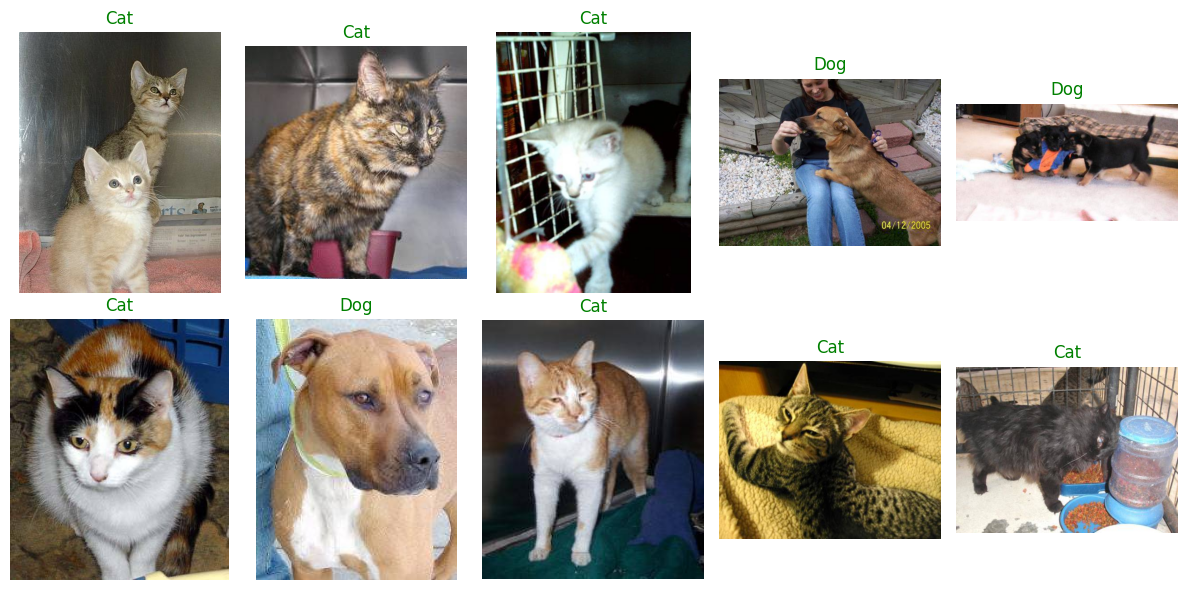

In [106]:
display_image(test_img_filepath)

- 아직 전처리하지 않은 이미지라 크기가 다 다르다.
- 이제 데이터셋을 읽고, 전처리하는 클래스를 정의하자.

In [43]:
class DogVsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase) # 사전에 구축한 클래스를 사용해서 전처리
        label = img_path.split('\\')[-1].split('.')[0] # 정규화하면 구분자가 '\\'임
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        
        return img_transformed, label

- 이제 이미지를 전처리 하자.
- 먼저 변수를 지정한다.

In [44]:
# parameter
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [45]:
# define dataset
train_dataset = DogVsCatDataset(train_img_filepath, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogVsCatDataset(val_img_filepath, transform=ImageTransform(size, mean, std), phase='val')

In [46]:
# 4번째 훈련 데이터 확인
idx = 3
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])

torch.Size([3, 224, 224])
1


- 224 X 224 크기의 이미지이다.
- 1이기 때문에 강아지 사진임을 알 수 있다.
- 이제 데이터로더를 정의해서 모델 학습을 위한 마지막 준비를 하자.

In [50]:
# define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

inputs, label = next(iter(train_dataloader))
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1])


- 배치 크기 32에 224 X 224 크기의 이미지가 있다.

### 4. Modeling

이제 데이터셋을 학습시키기 위한 신경망을 설계하자.

In [76]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1) 

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1) # 완전연결계층에 데이터 전달하기 위해 1차원으로 만듦
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)

        return out

신경망의 구조를 살펴보자.
1. 첫 번째 합성곱층
- 입력 데이터 : (3, 224, 244) = (채널 수(```in_channels```), 너비, 높이)
- 출력 데이터 : (16, 220, 220) = (채널 수(```out_channels```), 너비, 높이)
- 출력 데이터는 다음과 같이 계산함. {224(```input_volume_size```) - 5(```kernel_size```) + 2 * 0(```padding```)}/1(```stride```) + 1 = 220

2. ReLU 활성화 함수

3. 맥스 풀링 계층
- 출력 데이터는 (16, 110, 110)
- 출력 데이터는 다음과 같이 계산함. 220(```input_filter_size```)/2(```kernel_size```)

4. 두 번째 합성곱층
- 출력 데이터 : (32, 106, 106)

5. ReLU 활성화 함수

6. 맥스 풀링 계층
- 출력 데이터는 (32, 53, 53)

7. 첫 번째 완전 연결 계층
- 맥스 풀링 계층의 출력 결과를 1차원으로 만들기 위해 입력을 32*53*53
- 출력은 512

8. 두 번째 완전 연결 계층
- 이진 분류를 위해 512 -> 2

9. 소프트맥스 함수
- 확률값 출력

In [77]:
# model 확인 1
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [78]:
# model 확인 2
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

- 추정해야 할 파라미터가 약 4천만개가 넘는다.

In [79]:
# trainable parameter 확인 방법
def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [80]:
# 옵티마이저, 손실함수
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

In [87]:
# 모델 학습 함수
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # 모델을 학습
            else:
                model.eval() # 모델을 평가

            epoch_loss = 0.0
            epoch_corrects = 0.0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # 학습 시에만 기울기 전파
                    outputs = model(inputs)
                    _, pred = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0) # 기본으로 평균을 구하기 때문에 다시 배치 크기를 곱해줌
                    epoch_corrects += torch.sum(pred == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    return model

In [88]:
# 모델 학습 진행
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


train Loss: 0.6560 Acc: 0.6125


100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


val Loss: 0.6502 Acc: 0.6848
Epoch 2/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


train Loss: 0.6429 Acc: 0.6500


100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


val Loss: 0.6487 Acc: 0.6413
Epoch 3/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


train Loss: 0.6520 Acc: 0.6275


100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


val Loss: 0.6573 Acc: 0.5978
Epoch 4/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


train Loss: 0.6402 Acc: 0.6675


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


val Loss: 0.6561 Acc: 0.5652
Epoch 5/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


train Loss: 0.6346 Acc: 0.6550


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


val Loss: 0.6316 Acc: 0.6630
Epoch 6/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


train Loss: 0.6306 Acc: 0.6500


100%|██████████| 3/3 [00:00<00:00,  4.02it/s]


val Loss: 0.6690 Acc: 0.5543
Epoch 7/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


train Loss: 0.6373 Acc: 0.6600


100%|██████████| 3/3 [00:00<00:00,  4.05it/s]


val Loss: 0.6404 Acc: 0.6522
Epoch 8/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


train Loss: 0.6240 Acc: 0.6625


100%|██████████| 3/3 [00:00<00:00,  4.01it/s]


val Loss: 0.6416 Acc: 0.6196
Epoch 9/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


train Loss: 0.6343 Acc: 0.6475


100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


val Loss: 0.6473 Acc: 0.6196
Epoch 10/10
--------------------


100%|██████████| 13/13 [00:06<00:00,  2.06it/s]


train Loss: 0.6235 Acc: 0.6700


100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

val Loss: 0.6298 Acc: 0.6848
Training complete in 1m 11s
Best val Acc: 0.684783


- 검증 데이터셋을 활용한 모델 평가 최고 68% 정도의 정확도를 보인다.
- 물론 데이터를 400개로 제한해서 정확도가 낮게 나왔다고 할 수도 있다.
- 이제 test data로 모델의 결과를 확인해보자.

In [93]:
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_img_filepath):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist() # 각 행의 합이 1이 되도록 확률로 바꿔줌     
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({'id' : id_list,'label' : pred_list})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('LesNet.csv', index=False)

100%|██████████| 10/10 [00:00<00:00, 36.77it/s]


In [94]:
res

,id,label
0,105,0.612471
1,111,0.638286
2,116,0.642180
3,191,0.650759
4,198,0.703857
5,215,0.489427
6,22,0.616360
7,41,0.539916
8,57,0.503174
9,67,0.698848


- 예측 확률이 0.5를 넘으면 1, 즉 dog를 의미한다.
- 이제 시각화를 통해 정답이 맞았는지를 확인해보자.

In [127]:
class_ = classes = {0:'Cat', 1:'Dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # 예측값 확인
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        predicted_label = class_[label]

        # 실제값 확인
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]

        # 시각화
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title("Pred : {} / Ans : {}".format(str(predicted_label), str(true_label)), color=("green" if predicted_label==true_label else "red"))
        ax.ravel()[i].set_axis_off()
    
    plt.tight_layout()
    plt.show()

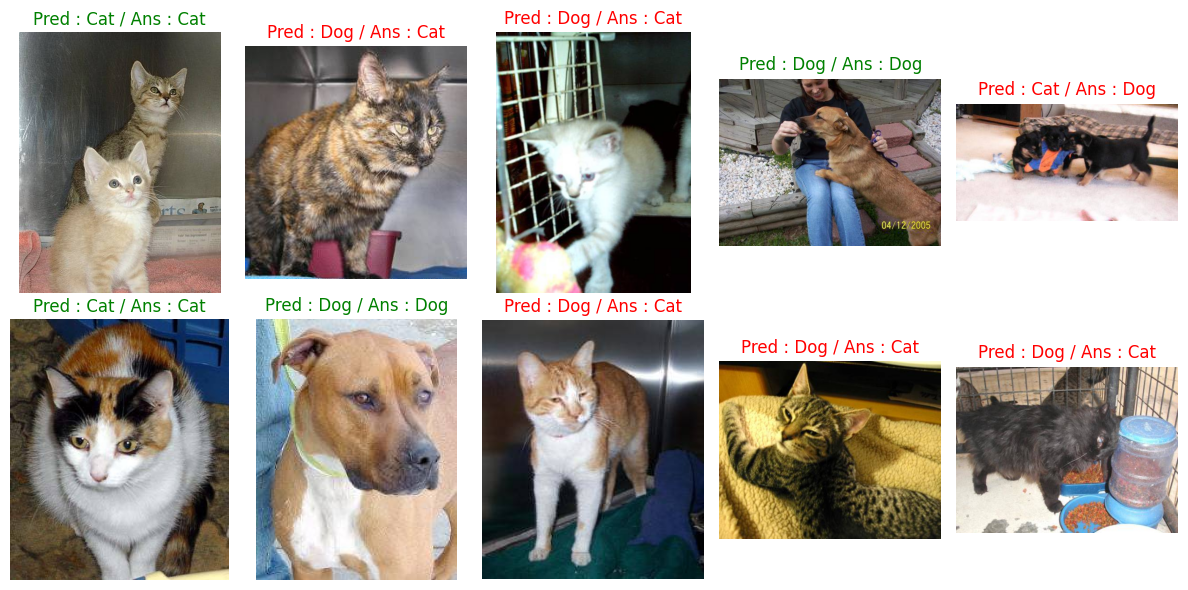

In [128]:
display_image_grid(test_img_filepath)

- 이렇게 시각화해서 보니 정답을 4개 밖에 맞추지 못했다...
- 학습 데이터를 늘리고 다시 결과를 확인해보는 방법이 좋을 것 같다.